In [ ]:
import time
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

In [ ]:
# X, y = make_blobs(n_samples=10000, centers=2, n_features=2, random_state=1, cluster_std=0.5)
X, y = make_blobs(n_samples=10000, centers=2, n_features=2, random_state=123)

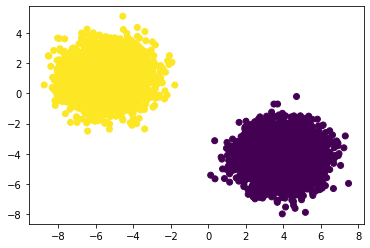

In [ ]:
plt.scatter(X.T[0], X.T[1], c=y)
plt.show()

In [ ]:
y[y == 0] = -1
y

array([-1,  1,  1, ..., -1,  1,  1])

In [ ]:
# first we shuffle and build the similarity matrix in order to separate later without shuffling and keep the form of the W matrix
X, y = shuffle(X, y, random_state=1)
# W = 1 / (pairwise_distances(X) + 0.0001)
W  = np.exp(-(euclidean_distances(X, squared=True)) * 0.5)
X_l, X_u, y_l, y_u , W_l, W_u = train_test_split(X, y, W, test_size = 0.97, shuffle=False)

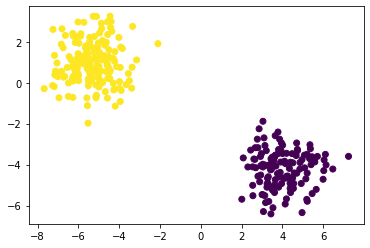

In [ ]:
# plot labeled datapoints
plt.scatter(X_l.T[0], X_l.T[1], c=y_l)
plt.show()

In [ ]:
# delete the first 300 columns from the similarity matrix as we don't need them
n = len(y_l)
W_l = W_l[:,n:]
W_u = W_u[:,n:]

In [ ]:
def calc_gradient(y, y_l, W_l, W_u):
    nl = len(y_l) # number of labeled points
    nu = len(y) # number of unlabeled points
    part1 = np.outer(np.ones(nl), y) - np.outer(y_l, np.ones(nu))
    part1 = np.multiply(W_l, part1)
    part1 = np.matmul(part1.T, np.ones(nl))

    part2 = np.outer(np.ones(nu), y) - np.outer(y, np.ones(nu))
    part2 = np.multiply(W_u, part2)
    part2 = np.matmul(part2.T, np.ones(nu))
    return 2 * (part1 + part2)

In [ ]:
def obj_func(y, y_l, W_l, W_u):
    nl = len(y_l) # number of labeled points
    nu = len(y) # number of unlabeled points
    part1 = np.outer(np.ones(nl), y) - np.outer(y_l, np.ones(nu))
    part1 = np.multiply(part1, part1)
    part1 = np.multiply(W_l, part1)

    part2 = np.outer(np.ones(nu), y) - np.outer(y, np.ones(nu))
    part2 = np.multiply(part2, part2)
    part2 = np.multiply(W_u, part2)
    return np.sum(part1) + (0.5 * np.sum(part2))

In [ ]:
#obj_func(np.zeros(9700)), obj_func(y_u)

### Calculate the Hessian

In [ ]:
def calc_hessian(W_l, W_u):
    hes = W_u * (-2)
    diag_values = (W_l.sum(axis=0) + W_u.sum(axis=0))
    np.fill_diagonal(hes, diag_values)
    return hes

In [ ]:
hessian = calc_hessian(W_l, W_u)
eigenvalues = np.linalg.eigvalsh(hessian)
eigenvalues

array([-1716.97510948, -1693.22675334,     9.32499355, ...,
        2493.09746732,  2493.26131001,  2493.32044689])

In [ ]:
L = np.max(eigenvalues)
lr = 1 / L
lr, L

(0.0004010715915981756, 2493.320446893873)

## Gradient descent

In [ ]:
# Gradient descent algorithm
def GM_algorithm(y_l, W_l, W_u, lr, max_iter, eps):
    loss_stat = [] # loss statistics
    time_stat = [] # time statistics
    y_pred = np.zeros(len(W_u))
    print(f"Initial loss: {obj_func(y_pred, y_l, W_l, W_u)}")
    for i in range(max_iter):
        start_grad = time.time()
        gradient = calc_gradient(y_pred, y_l, W_l, W_u)
        end_grad = time.time()
        time_stat.append(end_grad - start_grad)

        y_pred += -lr * gradient

        stop_cond = np.linalg.norm(gradient) * abs(lr)
        loss = obj_func(y_pred, y_l, W_l, W_u)
        loss_stat.append(loss)
        print(f"Iteration {i+1}: loss {loss}, gradient norm {stop_cond}")
        if stop_cond < eps:
            break
    return y_pred, loss_stat, time_stat

In [ ]:
start = time.time()
y_pred_GM, loss_stat_GM, time_stat_GM = GM_algorithm(y_l, W_l, W_u, 0.0004, 10000, 0.01)
end = time.time()
total_time_GM = end - start

Initial loss: 488748.93362724374
Iteration 1: loss 446626.05048792536, gradient norm 4.240696200473451
Iteration 2: loss 410329.4553005852, gradient norm 3.8689936084722314
Iteration 3: loss 377478.2660093786, gradient norm 3.6706558252212353
Iteration 4: loss 347470.70577991125, gradient norm 3.5048569599624333
Iteration 5: loss 319966.5604500904, gradient norm 3.353990556415798
Iteration 6: loss 294715.09655431885, gradient norm 3.212920670782843
Iteration 7: loss 271509.97185952344, gradient norm 3.0795203368240185
Iteration 8: loss 250172.60470816452, gradient norm 2.95268693923992
Iteration 9: loss 230544.535125694, gradient norm 2.831744745726835
Iteration 10: loss 212483.2744801865, gradient norm 2.716222870467002
Iteration 11: loss 195859.72170055498, gradient norm 2.6057601671505
Iteration 12: loss 180556.37021654347, gradient norm 2.500060008933997
Iteration 13: loss 166465.9565028665, gradient norm 2.3988669548494195
Iteration 14: loss 153490.3787413616, gradient norm 2.3019

In [ ]:
y_pred_GM

array([-0.99739633, -0.99750163,  0.99935194, ...,  0.99936756,
       -0.99745255,  0.99936896])

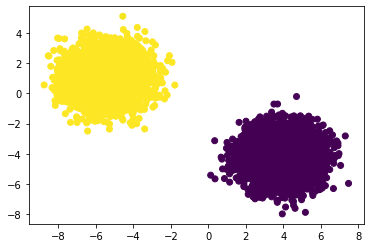

In [ ]:
# plotting the points and coloring them with the predicted values
plt.scatter(X_u.T[0], X_u.T[1], c=y_pred_GM)
plt.show()

## Randomized BCGD algorithm

In [ ]:
def rand_BCGD(y_l, W_l, W_u, lr, num_blocks, max_iter, eps, random_seed=None):
    np.random.seed(random_seed)
    loss_stat = [] # loss statistics
    time_stat = [] # time statistics
    y_pred = np.zeros(len(W_u))
    print(f"Initial loss: {obj_func(y_pred, y_l, W_l, W_u)}")

    # calculate the partition size for unlabeled data
    p_size_u = int(len(y_pred) / num_blocks)

    for iter in range(max_iter):
        # recoding the copy of old values in order to use the change as a stopping condition
        y_old = y_pred.copy()
        grad_time = 0
        for i in range(num_blocks):
            # choose random block
            ik = np.random.randint(0, num_blocks)
            # slice the blocks
            y_k = y_pred[(ik*p_size_u):((ik+1)*p_size_u)]
            W_l_k = W_l[:, (ik*p_size_u):((ik+1)*p_size_u)]
            W_u_k = W_u[(ik*p_size_u):((ik+1)*p_size_u), (ik*p_size_u):((ik+1)*p_size_u)]

            # calculate the gradient
            start = time.time()
            grad = calc_gradient(y_k, y_l, W_l_k, W_u_k)
            end = time.time()
            grad_time += end - start

            # update predictions
            y_k -= lr * grad
            y_pred[(ik*p_size_u):((ik+1)*p_size_u)] = y_k

        time_stat.append(grad_time)
        stop_cond = np.linalg.norm(y_old - y_pred)
        loss = obj_func(y_pred, y_l, W_l, W_u)
        loss_stat.append(loss)
        print(f"Interation {iter}, loss:  {loss}, norm: {stop_cond}")
        if stop_cond < eps:
          break

    return y_pred, loss_stat, time_stat

In [ ]:
# the calculated learning rate doesn't really work here, 0.001 is much better and faster
# included the random seed
start = time.time()
y_pred_RB, loss_stat_RB, time_stat_RB = rand_BCGD(y_l, W_l, W_u, lr, len(W_u), 1000, 0.01, 16)
end = time.time()
total_time_RB = end - start

NameError: ignored

In [ ]:
y_pred_RB

array([-0.99990776, -1.        ,  0.99999958, ...,  1.        ,
       -0.99999896,  1.        ])

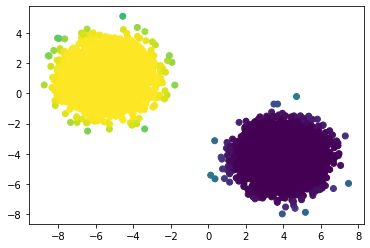

In [ ]:
plt.scatter(X_u.T[0], X_u.T[1], c=y_pred_RB)
plt.show()

## Cyclic BCGD algorithm

In [ ]:
def cycl_BCGD(y_l, W_l, W_u, lr, num_blocks, max_iter, eps):
    loss_stat = [] # loss statistics
    time_stat = [] # time statistics
    y_pred = np.zeros(len(W_u))
    print(f"Initial loss: {obj_func(y_pred, y_l, W_l, W_u)}")

    # calculate the partition size for unlabeled data
    p_size_u = int(len(y_pred) / num_blocks)

    for iter in range(max_iter):
        y_old = y_pred.copy()
        grad_time = 0
        for i in range(num_blocks):
            # slice the blocks
            y_k = y_pred[(i*p_size_u):((i+1)*p_size_u)]
            W_l_k = W_l[:, (i*p_size_u):((i+1)*p_size_u)]
            W_u_k = W_u[(i*p_size_u):((i+1)*p_size_u), (i*p_size_u):((i+1)*p_size_u)]

            # calculate the gradient
            start = time.time()
            grad = calc_gradient(y_k, y_l, W_l_k, W_u_k)
            end = time.time()
            grad_time += end - start

            # update predictions
            y_k -= lr * grad
            y_pred[(i*p_size_u):((i+1)*p_size_u)] = y_k

        time_stat.append(grad_time)
        loss = obj_func(y_pred, y_l, W_l, W_u)
        loss_stat.append(loss)

        stop_cond = np.linalg.norm(y_old - y_pred)
        print(f"Interation {iter}, loss:  {obj_func(y_pred, y_l, W_l, W_u)}, norm: {stop_cond}")
        if stop_cond < eps:
          break

    return y_pred, loss_stat, time_stat

In [ ]:
start = time.time()
y_pred_CB, loss_stat_CB, time_stat_CB = cycl_BCGD(y_l, W_l, W_u, lr, 9700, 10000, 0.01)
end = time.time()
total_time_CB = end - start

In [ ]:
y_pred_CB

array([-0.99975555, -1.        ,  0.99999449, ...,  0.99999999,
       -0.99999447,  0.99999999])

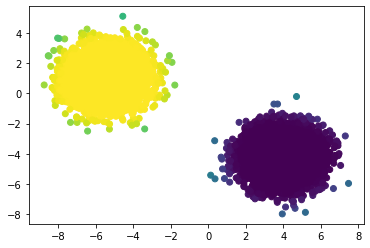

In [ ]:
plt.scatter(X_u.T[0], X_u.T[1], c=y_pred_CB)
plt.show()

## Plotting

### Plots with the step size = 1/L in all algorithms

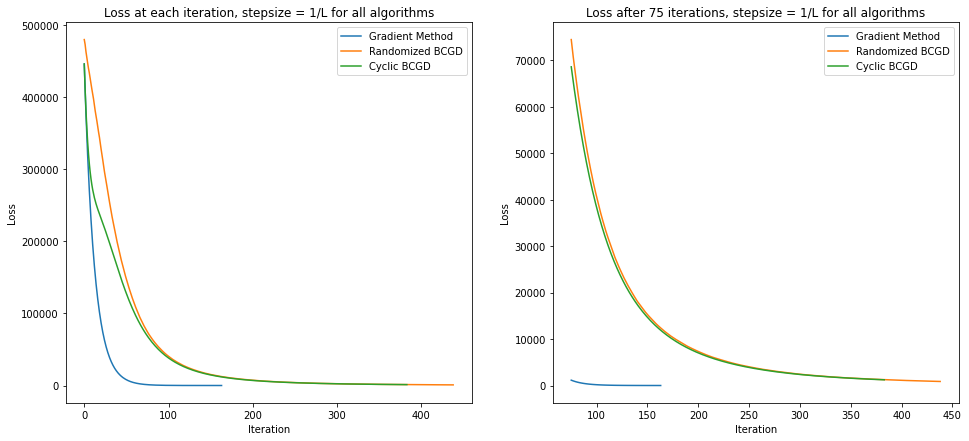

In [ ]:
# plotting loss and gradient computation time
# for BCGD the time for each gradient calculation in the number of blocks was summed
plt.figure(figsize=(16,7))
plt.subplot(1, 2, 1)
plt.plot(loss_stat_GM, label = "Gradient Method")
plt.plot(loss_stat_RB, label = "Randomized BCGD")
plt.plot(loss_stat_CB, label = "Cyclic BCGD")
plt.title("Loss at each iteration, stepsize = 1/L for all algorithms")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

# plot the loss after n iterations
n = 75
plt.subplot(1, 2, 2)
plt.plot(list(range(len(loss_stat_GM)))[n:], loss_stat_GM[n:], label = "Gradient Method")
plt.plot(list(range(len(loss_stat_RB)))[n:], loss_stat_RB[n:], label = "Randomized BCGD")
plt.plot(list(range(len(loss_stat_CB)))[n:], loss_stat_CB[n:], label = "Cyclic BCGD")
plt.title(f"Loss after {n} iterations, stepsize = 1/L for all algorithms")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()

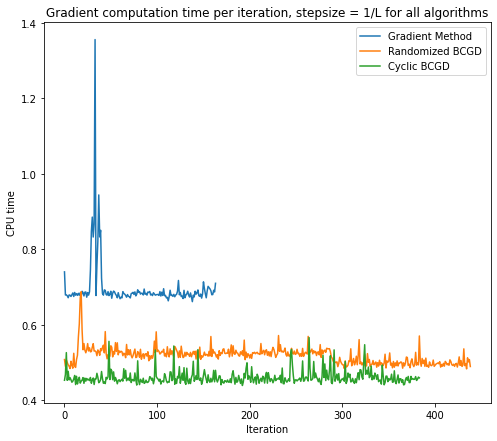

In [ ]:
plt.figure(figsize=(8,7))
plt.plot(time_stat_GM, label = "Gradient Method")
plt.plot(time_stat_RB, label = "Randomized BCGD")
plt.plot(time_stat_CB, label = "Cyclic BCGD")
plt.title("Gradient computation time per iteration, stepsize = 1/L for all algorithms")
plt.xlabel("Iteration")
plt.ylabel("CPU time")
plt.legend()
plt.show()

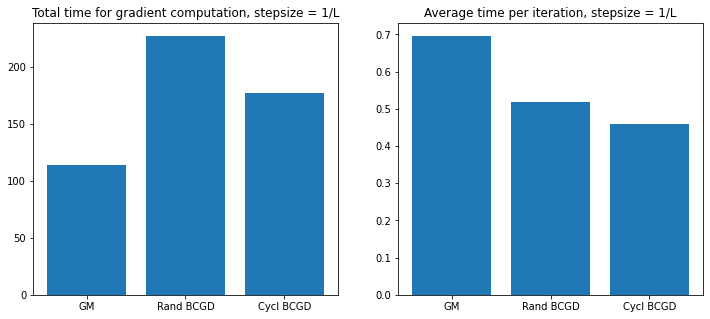

In [ ]:
# total and average gradient computation time
total_GM = np.array(time_stat_GM).sum()
total_RB = np.array(time_stat_RB).sum()
total_CB = np.array(time_stat_CB).sum()

avg_per_iter_GM = total_GM / len(time_stat_GM)
avg_per_iter_RB = total_RB / len(time_stat_RB)
avg_per_iter_CB = total_CB / len(time_stat_CB)

x_ticks = np.array(['GM', 'Rand BCGD', 'Cycl BCGD'])
total_time = np.array([total_GM, total_RB, total_CB])
avg_time = np.array([avg_per_iter_GM, avg_per_iter_RB, avg_per_iter_CB])

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.bar(x_ticks,total_time)
plt.title("Total time for gradient computation, stepsize = 1/L")

plt.subplot(1, 2, 2)
plt.bar(x_ticks,avg_time)
plt.title("Average time per iteration, stepsize = 1/L")
plt.show()

## Experiments

In [ ]:
y_pred_RB2, loss_stat_RB2, time_stat_RB2 = rand_BCGD(y_l, W_l, W_u, 0.001, 9700, 10000, 0.01, 16)

In [ ]:
y_pred_CB2, loss_stat_CB2, time_stat_CB2 = cycl_BCGD(y_l, W_l, W_u, 0.001, 9700, 10000, 0.01)

### Plots with the step size = 0.001 in BCGD

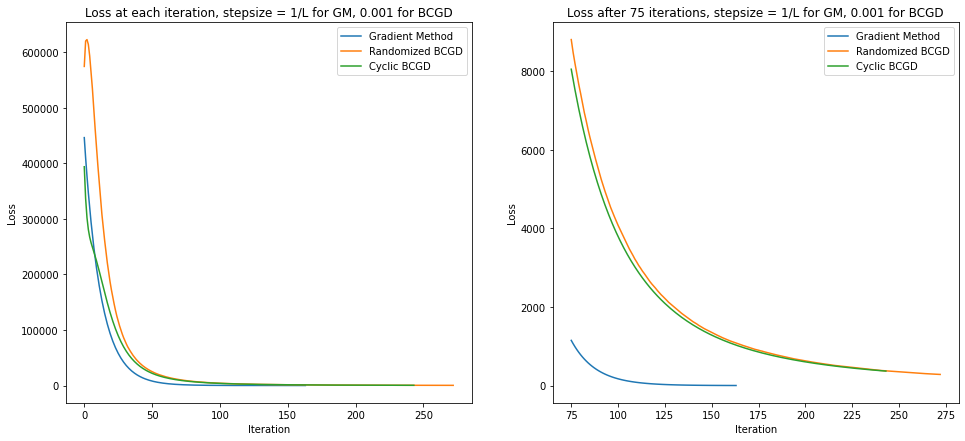

In [ ]:
# plotting loss and gradient computation time
# for BCGD the time for each gradient calculation in the number of blocks was summed
plt.figure(figsize=(16,7))
plt.subplot(1, 2, 1)
plt.plot(loss_stat_GM, label = "Gradient Method")
plt.plot(loss_stat_RB2, label = "Randomized BCGD")
plt.plot(loss_stat_CB2, label = "Cyclic BCGD")
plt.title("Loss at each iteration, stepsize = 1/L for GM, 0.001 for BCGD")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

# plot the loss after n iterations
n = 75
plt.subplot(1, 2, 2)
plt.plot(list(range(len(loss_stat_GM)))[n:], loss_stat_GM[n:], label = "Gradient Method")
plt.plot(list(range(len(loss_stat_RB2)))[n:], loss_stat_RB2[n:], label = "Randomized BCGD")
plt.plot(list(range(len(loss_stat_CB2)))[n:], loss_stat_CB2[n:], label = "Cyclic BCGD")
plt.title(f"Loss after {n} iterations, stepsize = 1/L for GM, 0.001 for BCGD")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()

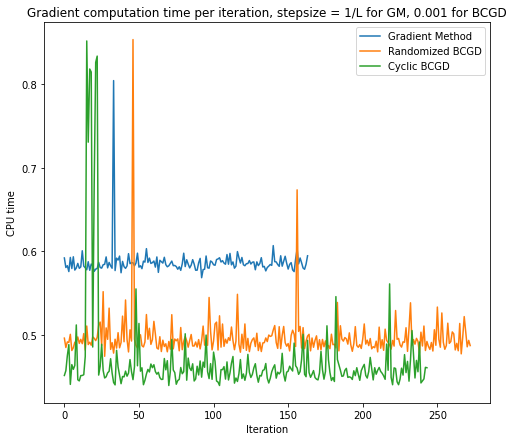

In [ ]:
plt.figure(figsize=(8,7))
plt.plot(time_stat_GM, label = "Gradient Method")
plt.plot(time_stat_RB2, label = "Randomized BCGD")
plt.plot(time_stat_CB2, label = "Cyclic BCGD")
plt.title("Gradient computation time per iteration, stepsize = 1/L for GM, 0.001 for BCGD")
plt.xlabel("Iteration")
plt.ylabel("CPU time")
plt.legend()
plt.show()

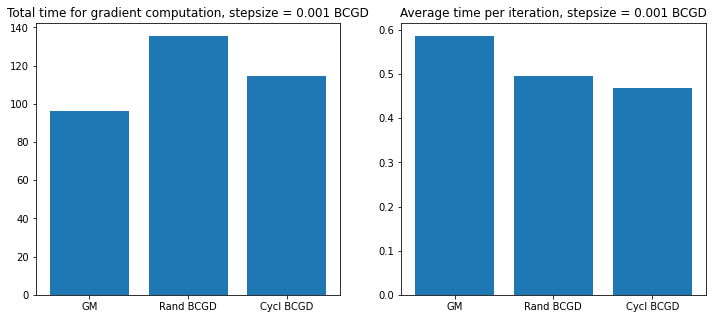

In [ ]:
# total and average gradient computation time
total_GM = np.array(time_stat_GM).sum()
total_RB = np.array(time_stat_RB2).sum()
total_CB = np.array(time_stat_CB2).sum()

avg_per_iter_GM = total_GM / len(time_stat_GM)
avg_per_iter_RB = total_RB / len(time_stat_RB2)
avg_per_iter_CB = total_CB / len(time_stat_CB2)

x_ticks = np.array(['GM', 'Rand BCGD', 'Cycl BCGD'])
total_time = np.array([total_GM, total_RB, total_CB])
avg_time = np.array([avg_per_iter_GM, avg_per_iter_RB, avg_per_iter_CB])

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.bar(x_ticks,total_time)
plt.title("Total time for gradient computation, stepsize = 0.001 BCGD")

plt.subplot(1, 2, 2)
plt.bar(x_ticks,avg_time)
plt.title("Average time per iteration, stepsize = 0.001 BCGD")
plt.show()

### Plots with the step size = 0.005 in BCGD

In [ ]:
y_pred_RB3, loss_stat_RB3, time_stat_RB3 = rand_BCGD(y_l, W_l, W_u, 0.005, 9700, 10000, 0.01, 16)
y_pred_CB3, loss_stat_CB3, time_stat_CB3 = cycl_BCGD(y_l, W_l, W_u, 0.005, 9700, 10000, 0.01)

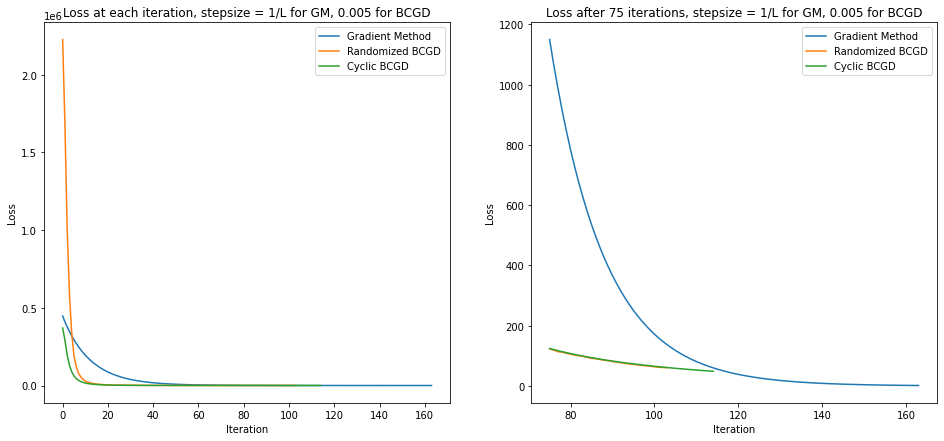

In [ ]:
# plotting loss and gradient computation time
# for BCGD the time for each gradient calculation in the number of blocks was summed
plt.figure(figsize=(16,7))
plt.subplot(1, 2, 1)
plt.plot(loss_stat_GM, label = "Gradient Method")
plt.plot(loss_stat_RB3, label = "Randomized BCGD")
plt.plot(loss_stat_CB3, label = "Cyclic BCGD")
plt.title("Loss at each iteration, stepsize = 1/L for GM, 0.005 for BCGD")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

# plot the loss after n iterations
n = 75
plt.subplot(1, 2, 2)
plt.plot(list(range(len(loss_stat_GM)))[n:], loss_stat_GM[n:], label = "Gradient Method")
plt.plot(list(range(len(loss_stat_RB3)))[n:], loss_stat_RB3[n:], label = "Randomized BCGD")
plt.plot(list(range(len(loss_stat_CB3)))[n:], loss_stat_CB3[n:], label = "Cyclic BCGD")
plt.title(f"Loss after {n} iterations, stepsize = 1/L for GM, 0.005 for BCGD")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()

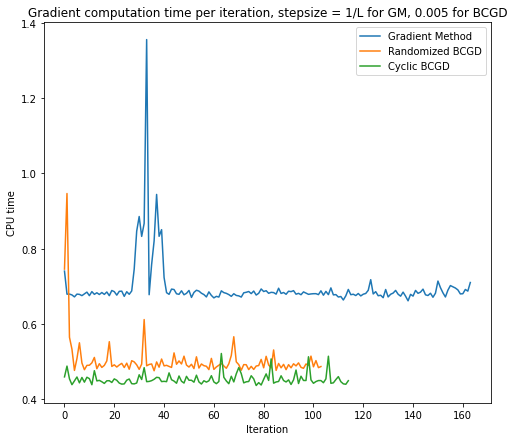

In [ ]:
plt.figure(figsize=(8,7))
plt.plot(time_stat_GM, label = "Gradient Method")
plt.plot(time_stat_RB3, label = "Randomized BCGD")
plt.plot(time_stat_CB3, label = "Cyclic BCGD")
plt.title("Gradient computation time per iteration, stepsize = 1/L for GM, 0.005 for BCGD")
plt.xlabel("Iteration")
plt.ylabel("CPU time")
plt.legend()
plt.show()

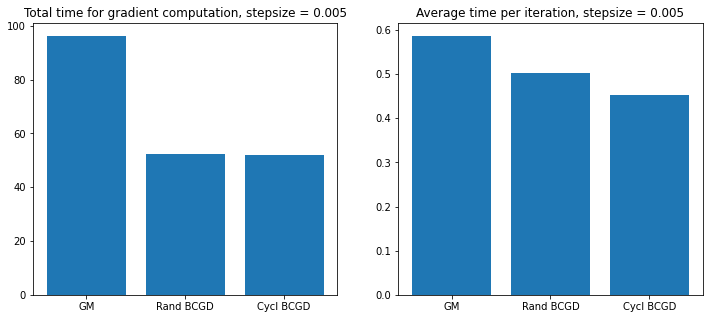

In [ ]:
# total and average gradient computation time
total_GM = np.array(time_stat_GM).sum()
total_RB = np.array(time_stat_RB3).sum()
total_CB = np.array(time_stat_CB3).sum()

avg_per_iter_GM = total_GM / len(time_stat_GM)
avg_per_iter_RB = total_RB / len(time_stat_RB3)
avg_per_iter_CB = total_CB / len(time_stat_CB3)

x_ticks = np.array(['GM', 'Rand BCGD', 'Cycl BCGD'])
total_time = np.array([total_GM, total_RB, total_CB])
avg_time = np.array([avg_per_iter_GM, avg_per_iter_RB, avg_per_iter_CB])

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.bar(x_ticks,total_time)
plt.title("Total time for gradient computation, stepsize = 0.005")

plt.subplot(1, 2, 2)
plt.bar(x_ticks,avg_time)
plt.title("Average time per iteration, stepsize = 0.005")
plt.show()

### Stepsize comparison

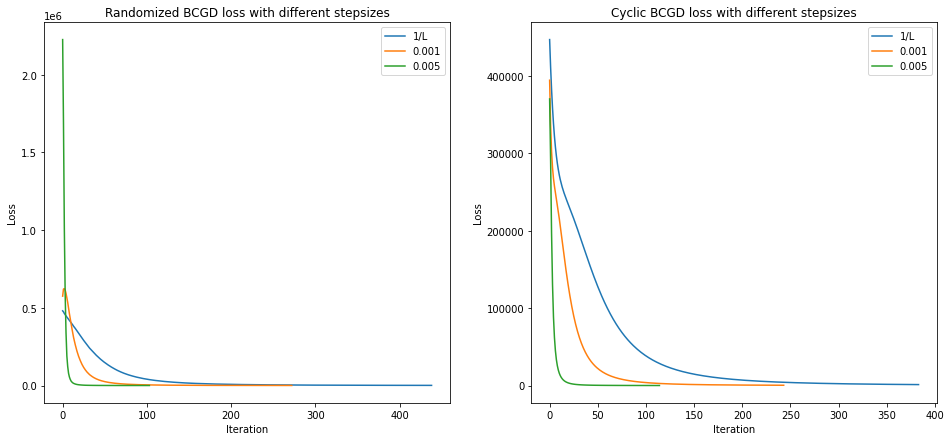

In [ ]:
plt.figure(figsize=(16,7))
plt.subplot(1, 2, 1)
plt.plot(loss_stat_RB, label = "1/L")
plt.plot(loss_stat_RB2, label = "0.001")
plt.plot(loss_stat_RB3, label = "0.005")
plt.title("Randomized BCGD loss with different stepsizes")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss_stat_CB, label = "1/L")
plt.plot(loss_stat_CB2, label = "0.001")
plt.plot(loss_stat_CB3, label = "0.005")
plt.title("Cyclic BCGD loss with different stepsizes")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Real Dataset

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import rbf_kernel # good with very small gamma
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv (r"citrus.csv")
print (df)

            name  diameter  weight  red  green  blue
0         orange      2.96   86.76  172     85     2
1         orange      3.91   88.05  166     78     3
2         orange      4.42   95.17  156     81     2
3         orange      4.47   95.60  163     81     4
4         orange      4.48   95.76  161     72     9
...          ...       ...     ...  ...    ...   ...
9995  grapefruit     15.35  253.89  149     77    20
9996  grapefruit     15.41  254.67  148     68     7
9997  grapefruit     15.59  256.50  168     82    20
9998  grapefruit     15.92  260.14  142     72    11
9999  grapefruit     16.45  261.51  152     74     2

[10000 rows x 6 columns]


In [ ]:
X = df[['diameter', 'weight', 'red', 'green', 'blue']].to_numpy()
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
scaler2 = MinMaxScaler(feature_range=(-100, 100))
scaler2.fit(X)
X = scaler2.transform(X)
X

array([[-100.        , -100.        ,   48.05194805,   27.05882353,
        -100.        ],
       [ -85.91549296,  -98.52360515,   32.46753247,   10.58823529,
         -96.2962963 ],
       [ -78.35433655,  -90.37482117,    6.49350649,   17.64705882,
        -100.        ],
       ...,
       [  87.24981468,   94.26609442,   37.66233766,   20.        ,
         -33.33333333],
       [  92.14232765,   98.43204578,  -29.87012987,   -3.52941176,
         -66.66666667],
       [ 100.        ,  100.        ,   -3.8961039 ,    1.17647059,
        -100.        ]])

In [ ]:
df.replace({'name': {'orange': -1, 'grapefruit': 1}}, inplace=True)
y = df['name'].to_numpy()
y

array([-1, -1, -1, ...,  1,  1,  1])

In [ ]:
df_scaled=df.copy()
df_scaled['diameter'] = X[:,0]
df_scaled['weight'] = X[:,1]
df_scaled['red'] = X[:,2]
df_scaled['green'] = X[:,3]
df_scaled['blue'] = X[:,4]

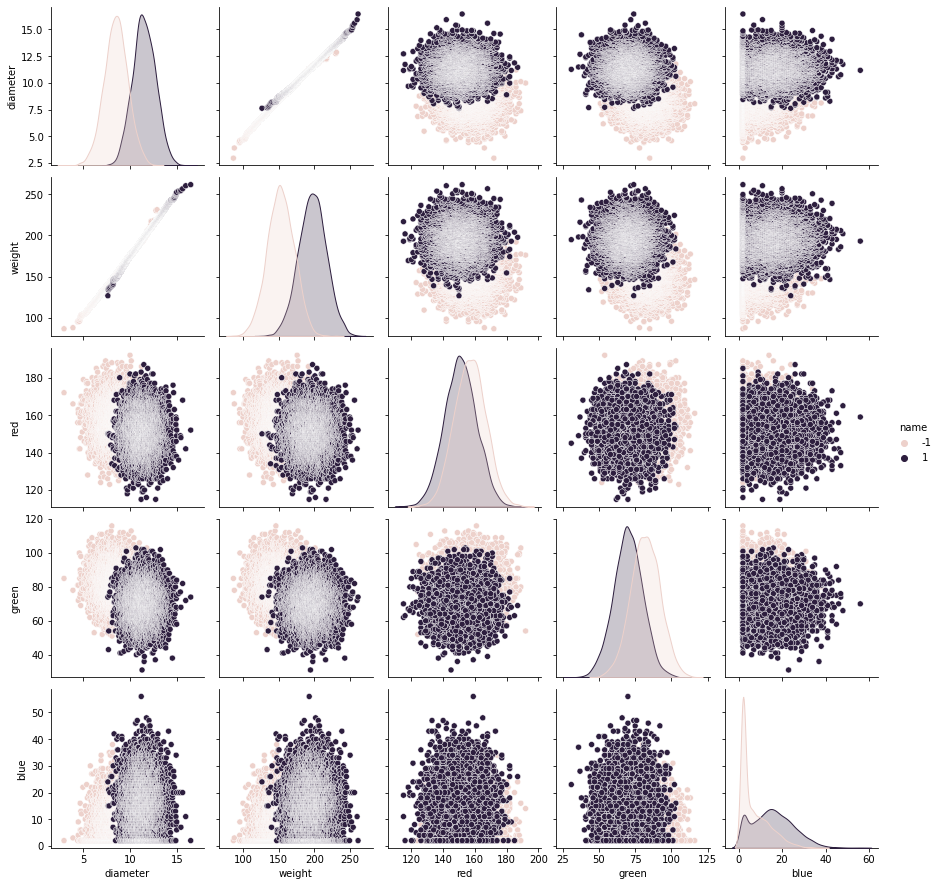

In [ ]:
sns.pairplot(df[['name', 'diameter', 'weight', 'red', 'green', 'blue']], hue='name');

In [ ]:
# first we shuffle and build the similarity matrix in order to separate later without shuffling and keep the form of the W matrix
X, y = shuffle(X, y, random_state=1)
W = rbf_kernel(X, gamma=1/100)
X_l, X_u, y_l, y_u , W_l, W_u = train_test_split(X, y, W, test_size = 0.97, shuffle=False)

In [ ]:
# delete the first 300 columns from the similarity matrix as we don't need them
n = len(y_l)
W_l = W_l[:,n:]
W_u = W_u[:,n:]

In [ ]:
print(obj_func(np.zeros(9700), y_l, W_l, W_u))

16849.659398804026


In [ ]:
def calc_hessian(W_l, W_u):
    hes = W_u * (-2)
    diag_values = (W_l.sum(axis=0) + W_u.sum(axis=0))
    np.fill_diagonal(hes, diag_values)
    return hes

eigenvalues = np.linalg.eigvalsh(calc_hessian(W_l, W_u))
lr1 = 1 / np.max(eigenvalues)

In [ ]:
y_pred_GM2, loss_stat_GM2, time_stat_GM2 = GM_algorithm(y_l, W_l, W_u, lr1, 10000, 0.01)

Initial loss: 2801.6675927750994
Iteration 1: loss , gradient norm 0.7228528815239067
Iteration 2: loss , gradient norm 0.6652109562594142
Iteration 3: loss , gradient norm 0.6248506429689117
Iteration 4: loss , gradient norm 0.5941065448965457
Iteration 5: loss , gradient norm 0.5693387529722297
Iteration 6: loss , gradient norm 0.5486008653273101
Iteration 7: loss , gradient norm 0.5307489280197547
Iteration 8: loss , gradient norm 0.5150595109226562
Iteration 9: loss , gradient norm 0.5010484176090019
Iteration 10: loss , gradient norm 0.4883767935284459
Iteration 11: loss , gradient norm 0.4767988448217786
Iteration 12: loss , gradient norm 0.4661309472072645
Iteration 13: loss , gradient norm 0.45623248599807636
Iteration 14: loss , gradient norm 0.44699348687053797
Iteration 15: loss , gradient norm 0.43832635829803246
Iteration 16: loss , gradient norm 0.4301602191288744
Iteration 17: loss , gradient norm 0.4224369043783277
Iteration 18: loss , gradient norm 0.41510809093435125


KeyboardInterrupt: ignored

In [ ]:
y_pred_GM2

(array([ 0.38078723,  0.2081432 , -0.33573097, ..., -0.74987916,
        -0.15523419, -0.73108077]),
 array([ 0.4863627 ,  0.02367498, -0.23436594, ..., -0.92801764,
         0.05649868, -0.6274452 ]),
 array([ 0.54351965,  0.42130856, -0.39136012, ..., -0.87857913,
        -0.05055244, -0.86673991]))

In [ ]:
y_pred_RB4, loss_stat_RB4, time_stat_RB4 = rand_BCGD(y_l, W_l, W_u, lr1, 9700, 1000, 0.01)

Initial loss: 9295.963658760078
Interation 0, loss:  9085.422538738798, norm: 2.634486341179385
Interation 1, loss:  8901.189424727114, norm: 2.539323649159192
Interation 2, loss:  8798.23860476314, norm: 2.471689217781717
Interation 3, loss:  8764.054244460825, norm: 2.3721058192279236
Interation 4, loss:  8666.004829033125, norm: 2.2446961696093135
Interation 5, loss:  8676.75410480065, norm: 2.12991204870523
Interation 6, loss:  8643.111038319868, norm: 1.9722513269900959
Interation 7, loss:  8645.83158313538, norm: 1.9213096735357578
Interation 8, loss:  8674.011148004782, norm: 1.899270142461795
Interation 9, loss:  8679.177288899904, norm: 1.8387163205576307
Interation 10, loss:  8724.53126055149, norm: 1.7178059891374955
Interation 11, loss:  8797.922477948026, norm: 1.6938089239333232
Interation 12, loss:  8854.16623768185, norm: 1.6280679670800347
Interation 13, loss:  8893.90614672456, norm: 1.5667187624498309
Interation 14, loss:  8937.877285329489, norm: 1.5085392047705324


KeyboardInterrupt: ignored

In [ ]:
y_pred_RB4

array([ 0.77197822,  0.05282883, -0.23094711, ..., -0.99354368,
        0.09590365, -0.84562832])

In [ ]:
y_pred_CB2, loss_stat_CB2, time_stat_CB2 = cycl_BCGD(y_l, W_l, W_u, lr1, 9700, 10000, 0.01)

In [ ]:
y_norm = [1 if i > 0 else -1 for i in y_pred_GM2]
y_norm = np.array(y_norm)
y_norm

array([ 1,  1, -1, ..., -1,  1, -1])

In [ ]:
np.sum(y_norm == y_u)

8936

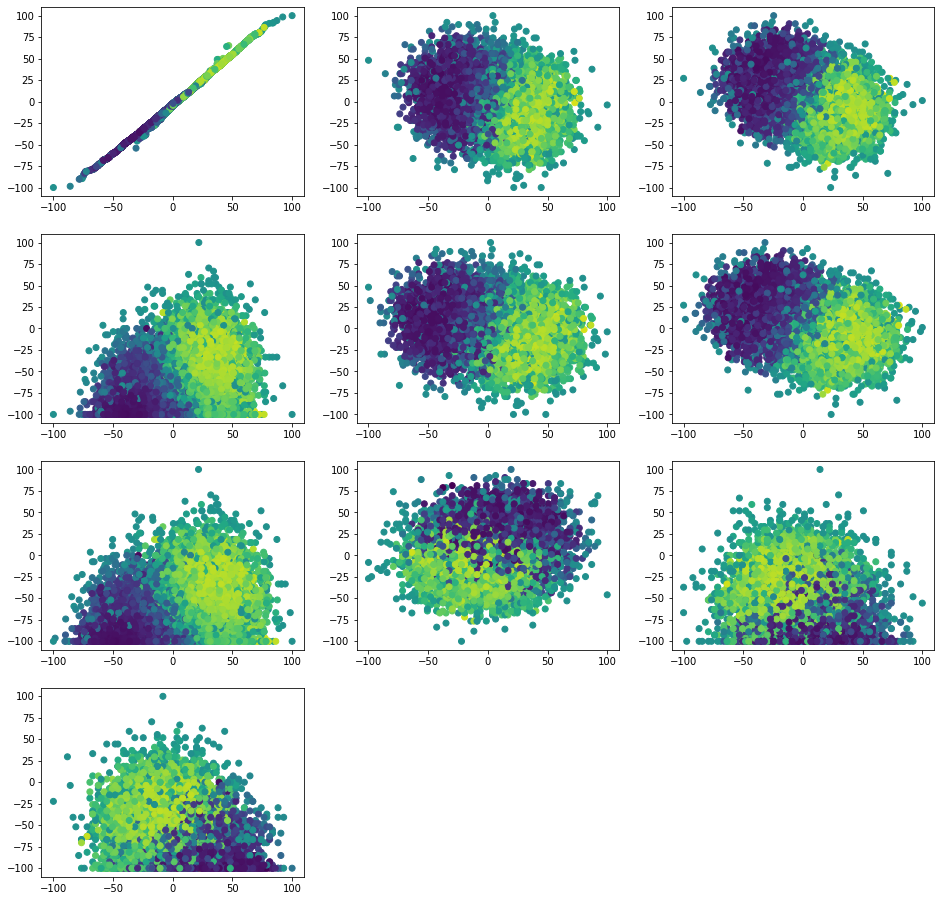

In [ ]:
predictions = y_pred_GM2
plt.figure(figsize=(16,16))
plt.subplot(4, 3, 1)
plt.scatter(X_u.T[0], X_u.T[1], c=predictions)

plt.subplot(4, 3, 2)
plt.scatter(X_u.T[0], X_u.T[2], c=predictions)

plt.subplot(4, 3, 3)
plt.scatter(X_u.T[0], X_u.T[3], c=predictions)

plt.subplot(4, 3, 4)
plt.scatter(X_u.T[0], X_u.T[4], c=predictions)

plt.subplot(4, 3, 5)
plt.scatter(X_u.T[1], X_u.T[2], c=predictions)

plt.subplot(4, 3, 6)
plt.scatter(X_u.T[1], X_u.T[3], c=predictions)

plt.subplot(4, 3, 7)
plt.scatter(X_u.T[1], X_u.T[4], c=predictions)

plt.subplot(4, 3, 8)
plt.scatter(X_u.T[2], X_u.T[3], c=predictions)

plt.subplot(4, 3, 9)
plt.scatter(X_u.T[2], X_u.T[4], c=predictions)

plt.subplot(4, 3, 10)
plt.scatter(X_u.T[3], X_u.T[4], c=predictions)
plt.show()

In [ ]:
cpu_stat_GM2 = np.cumsum(time_stat_GM2)
cpu_stat_RB2 = np.cumsum(time_stat_RB2)
cpu_stat_CB2 = np.cumsum(time_stat_CB2)

plt.figure(figsize=(8,7))
plt.plot(loss_stat_GM2, cpu_stat_GM2, label = "Gradient Method")
plt.plot(loss_stat_RB2, cpu_stat_RB2, label = "Randomized BCGD")
plt.plot(loss_stat_CB2, cpu_stat_CB2, label = "Cyclic BCGD")
plt.title("Loss VS Cumulative CPU time")
plt.xlabel("Iteration")
plt.ylabel("Cumulative CPU time")
plt.legend()

NameError: ignored

<Figure size 576x504 with 0 Axes>